In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

In [57]:
def f(a, b):
    return torch.sin(torch.pi * a) * torch.cos(torch.pi * b)

# Number of points on each axis
num_points_first_axis = 200
num_points_second_axis = 100

# create a grid of points in torch
first_axes = torch.linspace(-1, 3, num_points_first_axis)
second_axes = torch.linspace(-0.5, 1.5, num_points_second_axis)

# split first axis into 25% test set and 75% training set
test_split = 0.25
x_train, x_test = train_test_split(first_axes, test_size=test_split, shuffle=False)

# create meshgrids, 1 for training one for testing using torch
xx_train, yy_train = torch.meshgrid(x_train, second_axes, indexing='ij')
xx_test, yy_test = torch.meshgrid(x_test, second_axes, indexing='ij')

# create features and targets directly in torch
features_train = torch.stack((xx_train.flatten(), yy_train.flatten()), dim=1)
targets_train = f(xx_train, yy_train).view(-1, 1)
features_test = torch.stack((xx_test.flatten(), yy_test.flatten()), dim=1)
targets_test = f(xx_test, yy_test).view(-1, 1)

# print shapes
print(f'features_train.shape: {features_train.shape}')
print(f'targets_train.shape: {targets_train.shape}')
print(f'features_test.shape: {features_test.shape}')
print(f'targets_test.shape: {targets_test.shape}')

features_train.shape: torch.Size([15000, 2])
targets_train.shape: torch.Size([15000, 1])
features_test.shape: torch.Size([5000, 2])
targets_test.shape: torch.Size([5000, 1])


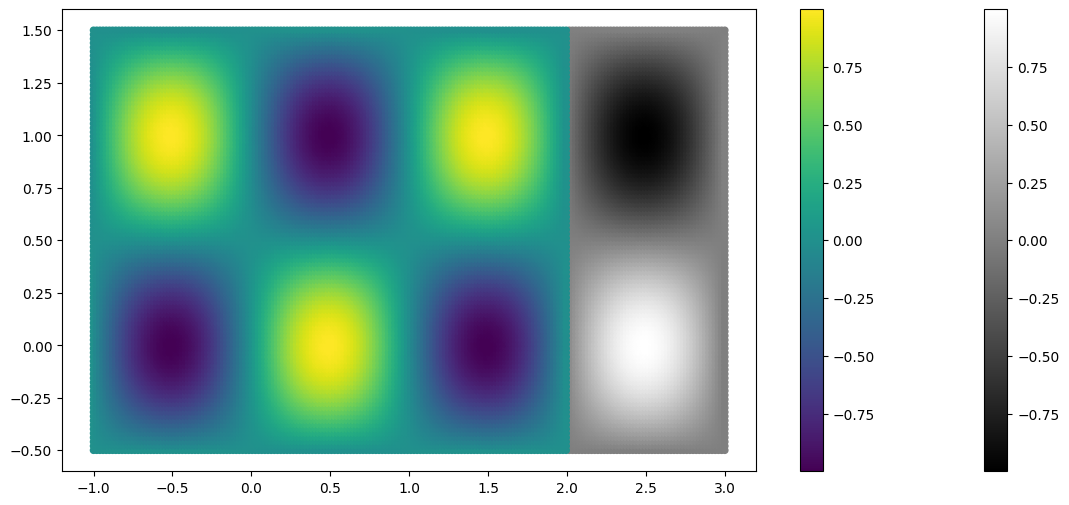

<Figure size 640x480 with 0 Axes>

In [3]:
# plot the data with colorbar
plt.figure(figsize=(14, 6), dpi=100)
plt.scatter(features_test[:, 0], features_test[:, 1], c=targets_test, s=20, cmap='gray')
plt.colorbar()
plt.scatter(features_train[:, 0], features_train[:, 1], c=targets_train, s=20, cmap='viridis')
plt.colorbar()
plt.show()
plt.tight_layout()


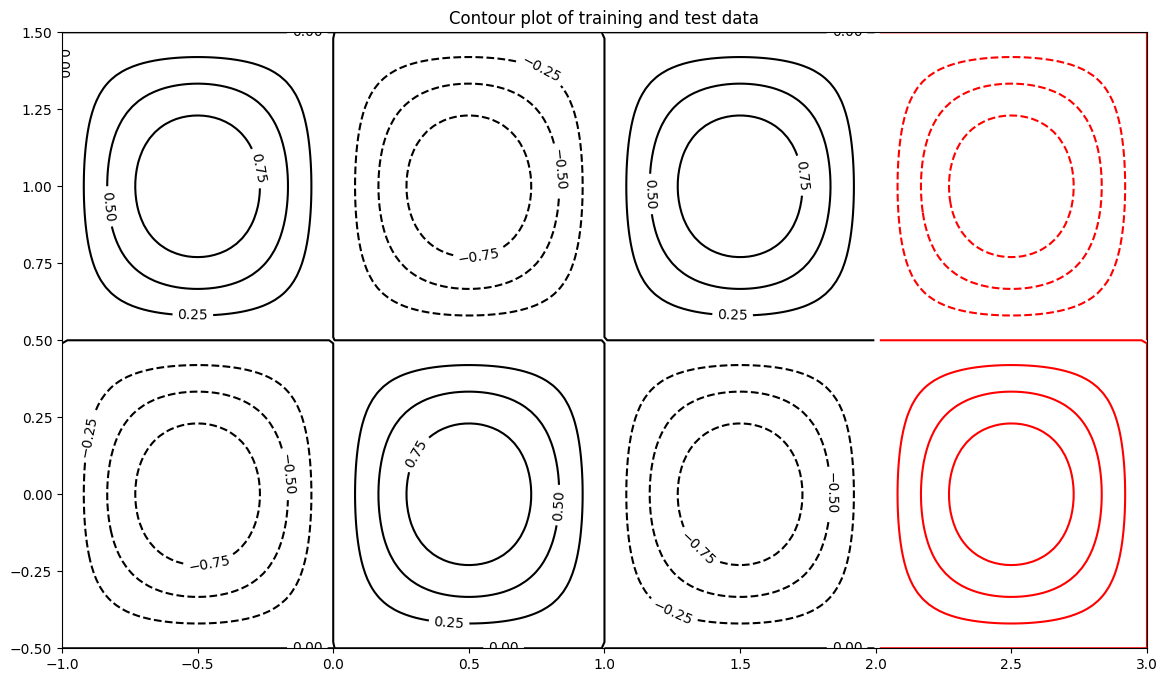

In [58]:
# contour plot with x_test and y_test
plt.rcParams['contour.negative_linestyle'] = 'dashed'
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
CS_train = ax.contour(xx_train, yy_train, targets_train.reshape(xx_train.shape), colors='black')
CS_test = ax.contour(xx_test, yy_test, targets_test.reshape(xx_test.shape), colors='red')
ax.clabel(CS_train, inline=1, fontsize=10)
plt.title('Contour plot of training and test data')
plt.show()

In [54]:
num_features = 2
hidden_dim1 = 128
hidden_dim2 = 256
hidden_dim3 = 128
num_outputs = 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # dropout
        self.dropout = nn.Dropout(0.5)
        

        self.network = nn.Sequential(
            nn.Linear(num_features, hidden_dim1), 
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_dim3, num_outputs)
        )
    
    def forward(self, x):
        return self.network(x)

In [59]:
class NetBasic(nn.Module):
    def __init__(self):
        super(NetBasic, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(num_features, hidden_dim1), 
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, x):
        return self.network(x)

In [60]:
# Instantiate the model
model = NetBasic()

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,) #weight_decay=1e-6)


Epoch 3501/4000, Loss: 9.809144830796868e-05


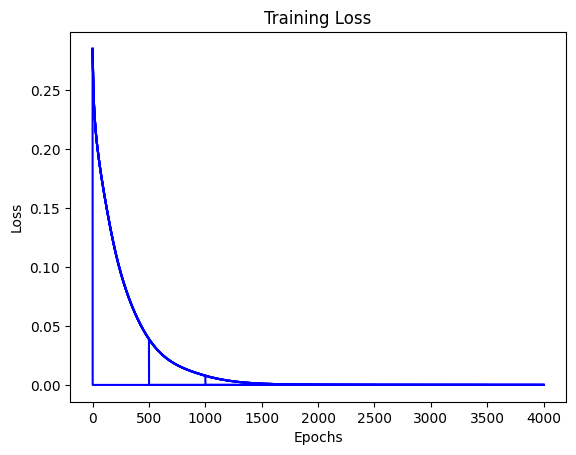

In [61]:

epochs = 4000

# Prepare the plot
fig, ax = plt.subplots()

losses = np.zeros(epochs)
epochs_x = np.arange(epochs)

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()           # Clear gradients for the next train
    output = model(features_train)         # Forward pass: Compute predicted y by passing x to the model
    loss = criterion(output, targets_train)# Compute loss
    loss.backward()                 # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()                # Update weights

    losses[epoch] = loss.item()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        
        # Plotting the loss
        ax.plot(epochs_x, losses, 'b')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss')
        # ax.set_xlim(left=max(0, epoch-500), right=epoch+100)  # Adjust the window of displayed data
        
        display.display(fig)
        display.clear_output(wait=True)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)

In [62]:
# Run the model on the train and test set to get predictions
model.eval()
with torch.no_grad():
    targets_train_pred = model(features_train).detach().numpy()
    targets_test_pred = model(features_test).detach().numpy()

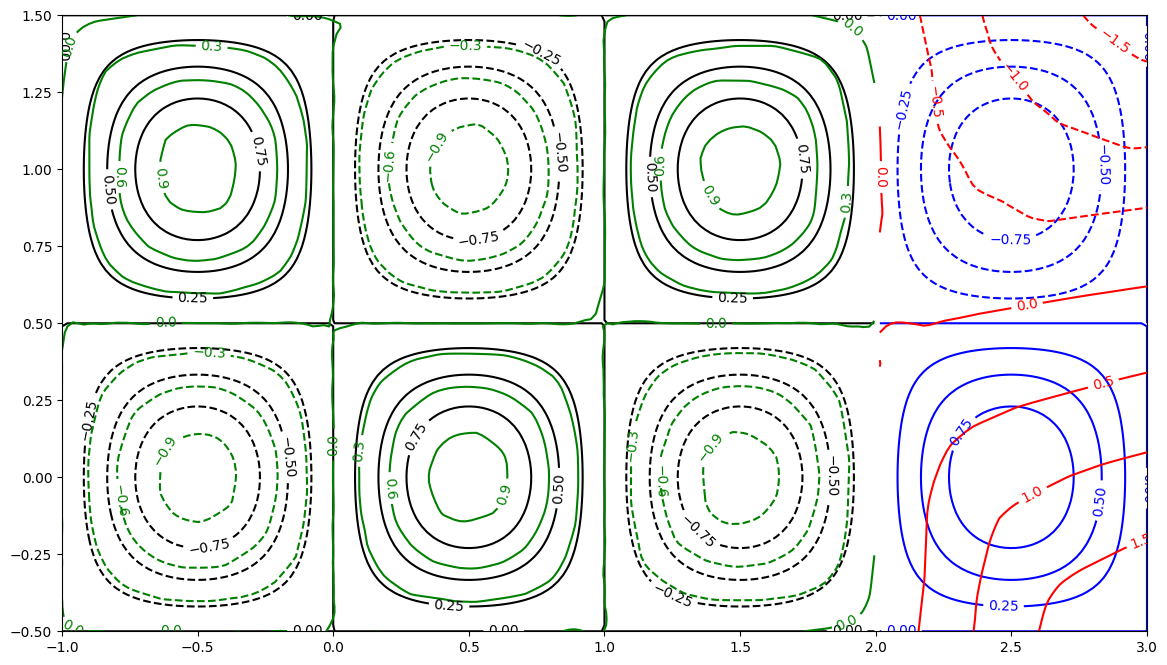

In [63]:
# contour plot with x_test and y_test
plt.rcParams['contour.negative_linestyle'] = 'dashed'
fig, ax = plt.subplots(figsize=(14, 8), dpi=100)
# train comparisons
CS_train = ax.contour(xx_train, yy_train, targets_train.reshape(xx_train.shape), colors='black')
CS_train_pred = ax.contour(xx_train, yy_train, targets_train_pred.reshape(xx_train.shape), colors='green')
# test comparisons
CS_test = ax.contour(xx_test, yy_test, targets_test.reshape(xx_test.shape), colors='blue')
CS_test_pred = ax.contour(xx_test, yy_test, targets_test_pred.reshape(xx_test.shape), colors='red')

ax.clabel(CS_train, inline=1, fontsize=10)
ax.clabel(CS_train_pred, inline=1, fontsize=10)
ax.clabel(CS_test, inline=1, fontsize=10)
ax.clabel(CS_test_pred, inline=1, fontsize=10)

plt.show()

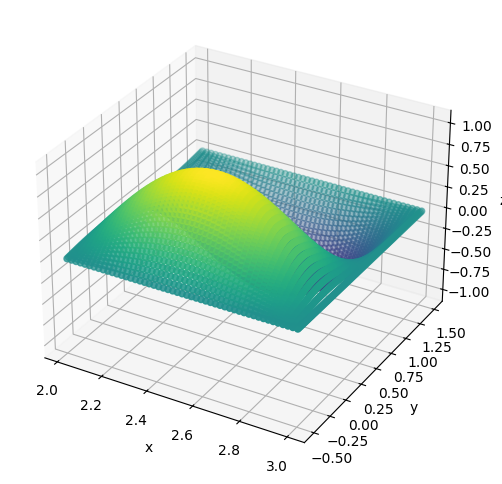

In [30]:
# plot 3d results from y_test and x_test
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_test[:, 0], features_test[:, 1], targets_test, c=targets_test)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
# plt.tight_layout()
